# Week 2 Package
## 27기 고경현

In [3]:
import pandas as pd
import numpy as np

## 1. 데이터 분할

### 1.1 데이터 불러오기

In [4]:
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

### 1.2 단위 수정

In [5]:
train_x, train_y = train.drop("price", axis = 1), train["price"]


### 1.3 validation set 분할 - 1

In [6]:
from sklearn.model_selection import train_test_split

In [7]:
x_train, x_valid, y_train, y_valid = train_test_split(train_x, train_y, test_size = 0.2, random_state = 1234)

### 1.4 해석

데이터에는 시간(year)가 독립 변수로 들어있습니다. 시계열 자료의 특성 상 자료들 간의 자기 상관이 존재하기 때문에 모든 자료를 독립적으로 보는 것은 시계열 자료의 특성을 반영하지 못합니다. 이를 무시한 채 데이터를 나눌 경우에 예측이 부정확해질 수 있습니다.

In [8]:
#! pip install category_encoders

In [9]:
from category_encoders.cat_boost import CatBoostEncoder

### 1.5 validation set 분할 - 2

In [17]:
val_set = train[train["transaction_year"] == 4]
train_set = train[train["transaction_year"] != 4]
x_valid, y_valid = val_set.drop("price", axis = 1), val_set["price"]
x_train, y_train = train_set.drop("price", axis = 1), train_set["price"]

### 1.6 캣부스트 인코딩

In [18]:
x_train_cbe = CatBoostEncoder().fit(x_train, y_train).transform(x_train)
x_valid_cbe = CatBoostEncoder().fit(x_train, y_train).transform(x_valid)
x_valid_cbe.head()

,dong,apt,exclusive_use_area,floor,transaction_year,until_trans,sin_date,cos_date
2451,89176.597368,86280.203194,107.91,14,4,9,-1.000000e+00,-1.836970e-16
2452,89176.597368,86280.203194,151.81,10,4,9,-1.000000e+00,-1.836970e-16
2453,89176.597368,86280.203194,94.51,2,4,9,-2.449294e-16,1.000000e+00
2454,89176.597368,86280.203194,94.28,12,4,9,-2.449294e-16,1.000000e+00
2455,103789.156533,107170.755379,145.96,13,4,13,-1.000000e+00,-1.836970e-16


## 2. 릿지 회귀

### 2.1 상관계수 플랏

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns 

<AxesSubplot:>

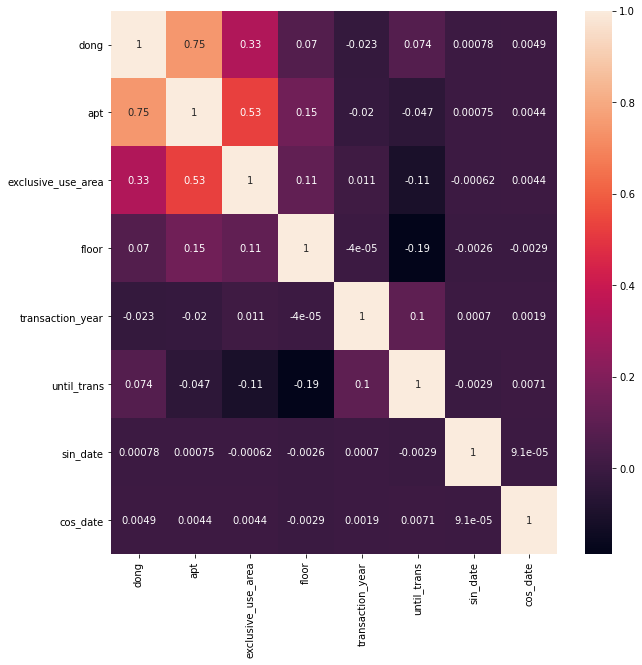

In [20]:
plt.figure(figsize = (10,10))
sns.heatmap(data = x_train_cbe.corr(), annot = True)

대부분의 변수들 간의 상관관계가 크게 높아보이지 않습니다. `dong`변수와 `apt`변수 간의 상관관계가 다른 것들에 비해 유독 높은데 이는 mean encoding을 했기에 그런 것으로 보입니다. 릿지 회귀는 변수들 간의 다중공선성이 클수록 그 효과가 크다고 알고 있지만, 이 데이터에서는 그렇지 않기 때문에 릿지 회귀가 크게 효과를 보일 것 같지는 않습니다.

### 2.2 릿지 튜닝

In [21]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error
from math import sqrt

In [22]:
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1]

In [23]:
ridge_fit_list = []
alpha = [0.00001, 0.0001, 0.001, 0.01, 0.1]
for a in alpha:
    ridge_fit = Ridge(alpha = a).fit(x_train_cbe, y_train)
    ridge_fit_list.append(ridge_fit)

In [24]:
ridge_fit_list

[Ridge(alpha=1e-05),
 Ridge(alpha=0.0001),
 Ridge(alpha=0.001),
 Ridge(alpha=0.01),
 Ridge(alpha=0.1)]

In [25]:
rmse_ridge = []

for a in alpha:
    ridge_fit = Ridge(alpha = a).fit(x_train_cbe, y_train)
    pred_y = ridge_fit.predict(x_valid_cbe)
    rmse = sqrt(mean_squared_error(y_valid,pred_y))
    rmse_ridge.append(rmse)

In [26]:
rmse_ridge

[15377.977659082708,
 15377.977659259472,
 15377.977661027064,
 15377.97767870299,
 15377.977855462259]

### 2.3 튜닝 결과 시각화

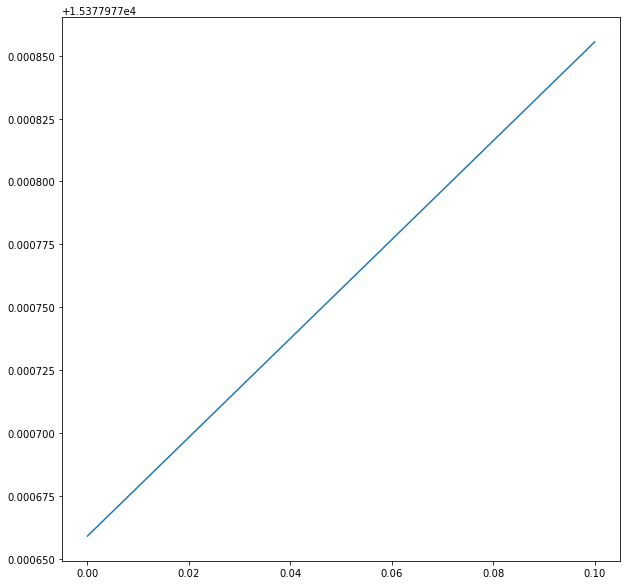

In [27]:
plt.figure(figsize = (10,10))
plt.plot(alpha, rmse_ridge)

### 2.4 해석

그래프 상으로는 변화가 커보이지만 rmse의 단위가 소수점 단위로 움직이기에 튜닝에 따른 변화가 크지 않다고 할 수 있습니다. 튜닝이 잘 되지 않았고, 모델 성능의 개선이 크게 없었습니다.

### 2.5 선형 회귀

In [28]:
from sklearn.linear_model import LinearRegression

In [29]:
lm = LinearRegression()
lm_fit = lm.fit(x_train_cbe, y_train)
yhat = lm_fit.predict(x_valid_cbe)
sqrt(mean_squared_error(y_valid, yhat))

15377.977659062744

In [30]:
rmse_ridge

[15377.977659082708,
 15377.977659259472,
 15377.977661027064,
 15377.97767870299,
 15377.977855462259]

큰 차이가 없기에 계산이 비교적 간편한 선형 회귀가 적합하다고 생각합니다.

## 3. LGBM

In [31]:
#! pip install lightgbm

In [32]:
import lightgbm as lgb
from lightgbm import LGBMModel,LGBMRegressor

### 3.1 LGBM 이해

LGBM은 gradient boosting을 사용하는 트리 기반 알고리즘입니다. LGBM은 다른 트리 기반 알고리즘과 다르게 아래 방향으로 뻗어나가는 경향이 강한 leaf-wise 방식으로 트리를 생성하기 때문에 계산 면에서 월등히 빠르다는 장점이 있습니다. 다만 이 때문에 데이터가 적을 경우 트리의 깊이가 빠르게 깊어지고 overfitting의 문제가 발생할 수 있다는 단점이 있습니다. 이는 파라미터튜닝으로 보완 가능합니다.

### 3.2 LGBM 튜닝

In [33]:
learning_rate = [0.01, 0.05, 0.1, 0.3, 0.7, 0.99]

In [39]:
rmse_lgbm = []
for rate in learning_rate:
    lgbm = LGBMRegressor(learning_rate = rate, 
                         n_estimators = 300,
                         max_depth = 10)
    lgbm_fit = lgbm.fit(x_train_cbe, y_train)
    yhat = lgbm_fit.predict(x_valid_cbe)
    rmse = np.sqrt(mean_squared_error(y_valid, yhat))
    rmse_lgbm.append(rmse)

rmse_lgbm

[12807.90653990061,
 10046.984169930956,
 9561.336955027273,
 8869.88710637223,
 10032.831425515771,
 10319.348932265224]

### 3.3 튜닝 결과 시각화

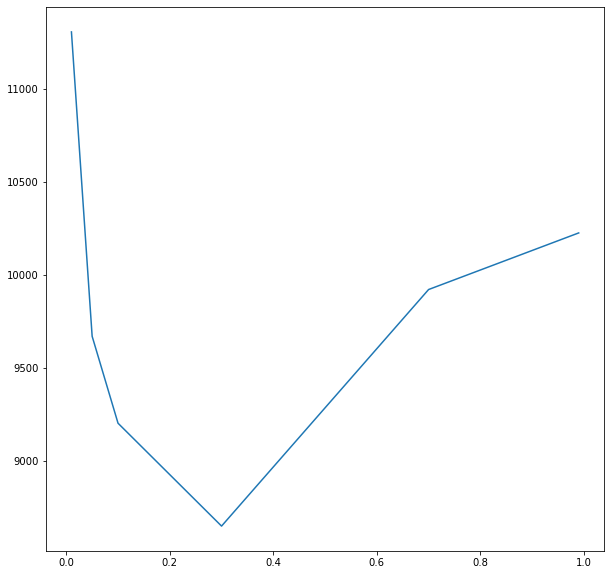

In [35]:
plt.figure(figsize = (10,10))
plt.plot(learning_rate, rmse_lgbm)

### 3.4 튜닝 설명

<p>
- Grid Search <br>
그리드 서치란 grid(격자)를 만들어 파라미터를 튜닝하는 방법으로, 조합 가능한 모든 파라미터의 조합으로 모델을 적합시키면서 최적의 파라미터를 찾는 과정입니다. 이때 조합 가능한 모든 파라미터는 사용자가 직접 입력해야합니다. 모든 파라미터 조합에 대해 모델을 적합하기 때문에 시간이 오래 걸립니다.
<p>
- Random Search <br>
랜덤 서치는 그리드 서치와 비슷하나 사용자가 일정 범위의 파라미터를 입력한다면 그 범위 내에서 파라미터 조합을 임의로 컴퓨터가 지정하여 서치를 진행합니다. 다만 확률에 의해 파라미터가 설정되기 때문에 정확도가 떨어질 수 있습니다.
<p>
- Bayesian Optimization <br>
베이지안 최적화는 모델의 성능을 평가할 지표, 즉 목적함수를 최대화하거나 최소화하는 파라미터를 찾기 위해 사전 정보를 활용합니다. 일정한 범위의 파라미터를 입력값으로 넣어준다면, 베이지안 최적화는 각각의 파라미터 조합에 대해 순차적으로 탐색하며 목적함수가 최대/최소가 되게하는 값을 찾습니다. 이때 순차적으로 탐색한다는 것은 초기 파라미터 조합으로 만들어진 모델(surrogant model)을 이용하여 이후 목적함수를 최대/최소화하는 파라미터 조합을 찾아낸다는 것입니다.


## 4. Test set

### 4.1 test set 불러오기

In [36]:
test = pd.read_csv("test.csv")
test_x, test_y = test.drop("price", axis=1), test["price"]

### 4.2 캣부스트 인코딩

In [37]:
train_x_cbe = CatBoostEncoder().fit(train_x, train_y).transform(train_x)
test_x_cbe = CatBoostEncoder().fit(train_x, train_y).transform(test_x)

### 4.3 최적의 파라미터 적합 -1 Linear Regression

In [43]:
lm_test_fit = lm.fit(train_x_cbe, train_y)
yhat_test = lm_test_fit.predict(test_x_cbe)
sqrt(mean_squared_error(yhat_test, test_y))

17721.88060515619

### 4.3 최적의 파라미터 적합 -2 LGBM w/ learning_rate = .3

In [42]:
lgbm_test = LGBMRegressor(learning_rate = 0.3, 
                              n_estimators = 300,
                              max_depth = 10)
lgbm_test_fit = lgbm_test.fit(train_x_cbe, train_y)
yhat_test = lgbm_test_fit.predict(test_x_cbe)
sqrt(mean_squared_error(yhat_test, test_y))

11351.788065674182

### 4.4 test set에 대해 평가

RMSE 값이 낮은 LGBM 모델을 통한 예측이 Ridge 회귀모델에 비해 비교적 정확했습니다.